In [1]:
# HIDE
%load_ext autoreload
%autoreload 2

In [2]:
# HIDE
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fairness.helpers import load_ICU_data
from fairness.helpers import plot_distributions


torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline

In [21]:
categorical_cols

Index(['country_Canada', 'country_El-Salvador', 'country_Germany',
       'country_Mexico', 'country_United-States', 'country_Unknown',
       'education_11th', 'education_12th', 'education_1st-4th',
       'education_5th-6th', 'education_7th-8th', 'education_9th',
       'education_Assoc-acdm', 'education_Assoc-voc', 'education_Bachelors',
       'education_Doctorate', 'education_HS-grad', 'education_Masters',
       'education_Prof-school', 'education_Some-college',
       'martial_status_Married-civ-spouse',
       'martial_status_Married-spouse-absent', 'martial_status_Never-married',
       'martial_status_Separated', 'martial_status_Widowed',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_T

In [22]:
# HIDE

# load ICU data set
X, y, Z = load_ICU_data('data/adult.data')

numerical_cols = ['age', 'education_num', 'capital_gain', 'capital_loss',
                   'hours_per_week']
categorical_cols = X.columns.difference(numerical_cols + ['relationship_Wife'] + X.columns[X.sum() < 100].tolist()
                                        + X.columns[X.columns.str.startswith('relationship')].tolist() +
                                         X.columns[X.columns.str.startswith('martial')].tolist())

X_num = X.loc[:, numerical_cols]
X_cat = X.loc[:, categorical_cols]
n_features = X.shape[1]
n_num_features = X_num.shape[1]
n_cat_features = X_cat.shape[1]
n_features = n_num_features + n_cat_features
n_sensitive = Z.shape[1]

# # split into train/test set
(X_train, X_test, y_train, y_test,
 Z_train, Z_test, X_num_train, X_num_test,
 X_cat_train, X_cat_test) = train_test_split(X, y, Z, X_num, X_cat, test_size=0.5,
                                     stratify=y, random_state=7)

# # standardize the data
scaler = StandardScaler().fit(X_num_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), 
                                           columns=df.columns, index=df.index)
X_num_train = X_num_train.pipe(scale_df, scaler) 
X_num_test = X_num_test.pipe(scale_df, scaler) 

X_train = pd.concat([X_num_train, X_cat_train], axis=1)
X_test = pd.concat([X_num_test, X_cat_test], axis=1)

features X: 30940 samples, 93 attributes
targets y: (30940,) samples
sensitives Z: 30940 samples, 2 attributes


In [23]:
class PandasDataSet(TensorDataset):

    def __init__(self, *dataframes):
        tensors = (self._df_to_tensor(df) for df in dataframes)
        super(PandasDataSet, self).__init__(*tensors)

    def _df_to_tensor(self, df):
        if isinstance(df, pd.Series):
            df = df.to_frame('dummy')
        return torch.from_numpy(df.values).float()


train_data = PandasDataSet(X_train, y_train, Z_train, X_num_train, X_cat_train)
test_data = PandasDataSet(X_test, y_test, Z_test, X_num_train, X_cat_train)

In [24]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)

print('# training samples:', len(train_data))
print('# batches:', len(train_loader))

# training samples: 15470
# batches: 483


In [25]:
class PreNumerical(nn.Module):

    def __init__(self, n_features, n_sensitive, n_hidden=32, p_dropout=0.2):
        super(PreNumerical, self).__init__()
        self.network = nn.Sequential(
#             nn.Linear(n_sensitive, n_features),  # DELETE
            nn.Linear(n_sensitive, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_features),
        )

    def forward(self, x):
        return self.network(x)
    
    
class PreCategorical(nn.Module):

    def __init__(self, n_features, n_sensitive, n_hidden=32, p_dropout=0.2):
        super(PreCategorical, self).__init__()
        self.network = nn.Sequential(
#             nn.Linear(n_sensitive, n_features),  # DELETE
            nn.Linear(n_sensitive, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_features),
#             nn.ReLU(),
#             nn.Dropout(p_dropout),
        )

    def forward(self, x):
        return F.sigmoid(self.network(x))

In [26]:
num = PreNumerical(n_features=n_num_features, n_sensitive=Z.shape[1])
num_criterion = nn.MSELoss()
num_optimizer = optim.Adam(num.parameters(), amsgrad=True)

cat = PreCategorical(n_features=n_cat_features, n_sensitive=Z.shape[1])
cat_criterion = nn.BCELoss()
cat_optimizer = optim.Adam(cat.parameters(), amsgrad=True)

In [27]:
for epoch in range(10):
    for _, _, z, x_num, x_cat in train_loader:
        num.zero_grad()
        x_num_pred = num(z)
        num_loss = num_criterion(x_num_pred, x_num)
        num_loss.backward()
        num_optimizer.step()
        
        cat.zero_grad()
        x_cat_pred = cat(z)
        cat_loss = cat_criterion(x_cat_pred, x_cat)
        cat_loss.backward()
        cat_optimizer.step()        
        
    with torch.no_grad():
        x_num_pred = num(test_data.tensors[2])
        num_loss = num_criterion(x_num_pred, test_data.tensors[3])
        x_cat_pred = cat(test_data.tensors[2])
        cat_loss = cat_criterion(x_cat_pred, test_data.tensors[4])
    print(epoch, 'num', num_loss, 'cat', cat_loss)

0 num tensor(1.0126) cat tensor(0.2125)
1 num tensor(1.0121) cat tensor(0.2125)
2 num tensor(1.0166) cat tensor(0.2121)
3 num tensor(1.0118) cat tensor(0.2115)
4 num tensor(1.0133) cat tensor(0.2114)
5 num tensor(1.0134) cat tensor(0.2111)
6 num tensor(1.0102) cat tensor(0.2106)
7 num tensor(1.0108) cat tensor(0.2112)
8 num tensor(1.0146) cat tensor(0.2107)
9 num tensor(1.0121) cat tensor(0.2108)


In [28]:
ii = 1

pred = x_cat_pred.numpy()[:, ii]
true = test_data.tensors[4].numpy()[:, ii]

In [38]:
# (Z_train.loc[X_train['martial_status_Married-civ-spouse'] == 1, 'sex'] == 0).all()

In [39]:
X_train.corrwith(Z_train['sex']).sort_values()

occupation_Other-service       -0.160142
occupation_Priv-house-serv     -0.081233
education_Some-college         -0.065534
workclass_Unknown              -0.062125
occupation_Unknown             -0.061436
workclass_Private              -0.039097
workclass_Local-gov            -0.032544
education_Assoc-acdm           -0.031715
occupation_Prof-specialty      -0.031587
workclass_State-gov            -0.020244
education_Assoc-voc            -0.019281
occupation_Sales               -0.018568
occupation_Tech-support        -0.018406
education_11th                 -0.017607
education_12th                 -0.004725
country_United-States          -0.003851
country_Germany                -0.003828
country_Canada                  0.003777
education_Masters               0.008812
country_El-Salvador             0.008867
education_num                   0.012176
education_HS-grad               0.013186
education_1st-4th               0.015362
country_Unknown                 0.019359
education_7th-8t

In [40]:
np.unique(pred)

array([ 0.00011678,  0.00012916,  0.00015023, ...,  0.05128062,
        0.06324913,  0.09066115], dtype=float32)

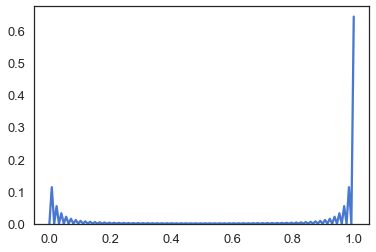

In [41]:
sns.kdeplot(true)

/Users/henkgriffioen/anaconda3/envs/fairness-in-ml/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


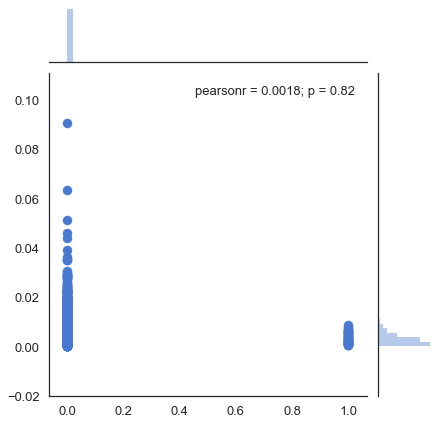

In [42]:
sns.jointplot(true, pred)

In [43]:
class Classifier(nn.Module):

    def __init__(self, n_features, n_hidden=32, p_dropout=0.2):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
#             nn.Linear(n_hidden, n_hidden),
#             nn.ReLU(),
#             nn.Dropout(p_dropout),
#             nn.Linear(n_hidden, n_hidden),
#             nn.ReLU(),
#             nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1),
        )

    def forward(self, x):
        return F.sigmoid(self.network(x))

In [44]:
clf = Classifier(n_features=n_features)
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters(), amsgrad=True)

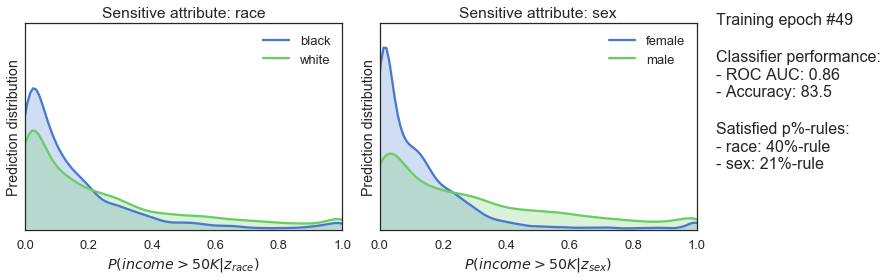

49 tensor(0.3734) tensor(1.0148) tensor(0.2100)


In [45]:
for epoch in range(50):
    for x, y, z, x_num, x_cat in train_loader:
        
        num.zero_grad()
        x_num_pred = num(z)
        num_loss = num_criterion(x_num_pred, x_num)
        num_loss.backward()
        num_optimizer.step()
        
        cat.zero_grad()
        x_cat_pred = cat(z)
        cat_loss = cat_criterion(x_cat_pred, x_cat)
        cat_loss.backward()
        cat_optimizer.step()    
        
        x_pred = torch.cat((num(z), cat(z)), dim=1).detach()
        
        clf.zero_grad()
        epsilon = x - x_pred
        y_pred = clf(epsilon)
        clf_loss = clf_criterion(y_pred, y)
        clf_loss.backward()
        clf_optimizer.step()  

    with torch.no_grad():
        x_num_pred = num(test_data.tensors[2])
        num_loss = num_criterion(x_num_pred, test_data.tensors[3])
        x_cat_pred = cat(test_data.tensors[2])
        cat_loss = cat_criterion(x_cat_pred, test_data.tensors[4])
        x_pred = torch.cat((x_num_pred, x_cat_pred), dim=1)
        epsilon = test_data.tensors[0] - x_pred
        y_pred = clf(epsilon)
        clf_loss = clf_criterion(y_pred, test_data.tensors[1])
    
    print(epoch, clf_loss, num_loss, cat_loss)    
    test = (
        pd.DataFrame(y_pred.numpy(), columns=['pred'], index=y_test.index)
            .assign(true=y_test)
    )
    plot_distributions(y_test, Z_test, test['pred'], epoch=epoch)
    display.clear_output(wait=True)
    plt.show(plt.gcf())
    print(epoch, clf_loss, num_loss, cat_loss)    

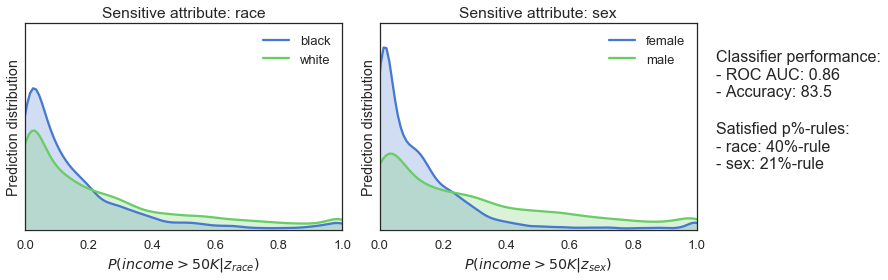

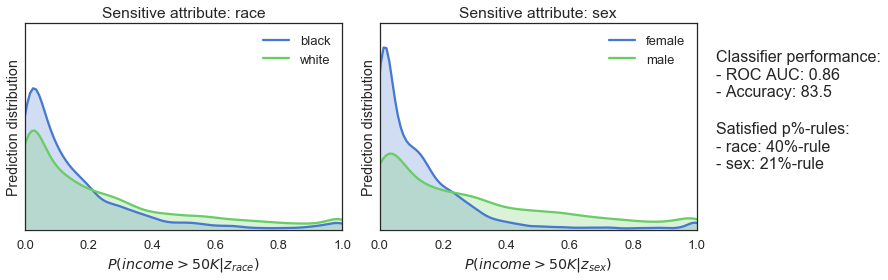

In [46]:
test = (
    pd.DataFrame(y_pred.numpy(), columns=['pred'], index=y_test.index)
    .assign(true=y_test)
)

plot_distributions(y_test, Z_test, test['pred'])

In [20]:

for x, y, z in train_loader:
    pass
    

ValueError: too many values to unpack (expected 3)